# STEP1 Install the library

In [1]:
!pip install quandl

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

# STEP2 Import data set

In [3]:
quandl.ApiConfig.api_key = '5AJr1rnX7i2mXr66a_X5'

In [5]:
data = quandl.get('FRED/DFF')

DFF refer to 'Effective Federal Funds Rate'

In [6]:
data.head()

,Value
Date,
1954-07-01,1.13
1954-07-02,1.25
1954-07-03,1.25
1954-07-04,1.25
1954-07-05,0.88


In [12]:
data.tail()

,Value
Date,
2022-07-11,1.58
2022-07-12,1.58
2022-07-13,1.58
2022-07-14,1.58
2022-07-15,1.58


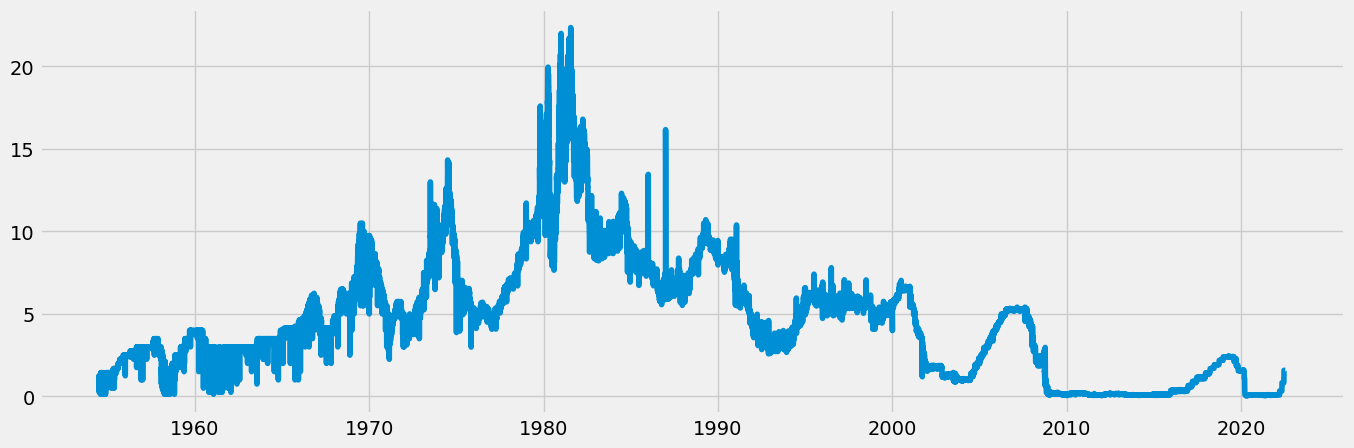

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

# STEP3 Subsetting, wrangling, and cleaning time-series data

In [13]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [14]:
data_sub = data_2.loc[(data_2['Date'] >= '1990-01-01') & (data_2['Date'] < '2022-06-01')]

In [15]:
data_sub.shape

(11839, 2)

The reason for selecting the Federal Funds Rate data from 1990 to 2022 is that this data has shown a downward trend since 1990, whereas before 1990 it was on an upward trend. To better analyze and predict, it is more effective to choose data that aligns with the current situation.

In [16]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1990-01-01,7.97
1990-01-02,8.54
1990-01-03,8.37
1990-01-04,8.29
1990-01-05,8.20


In [18]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

# STEP4 Create a line chart

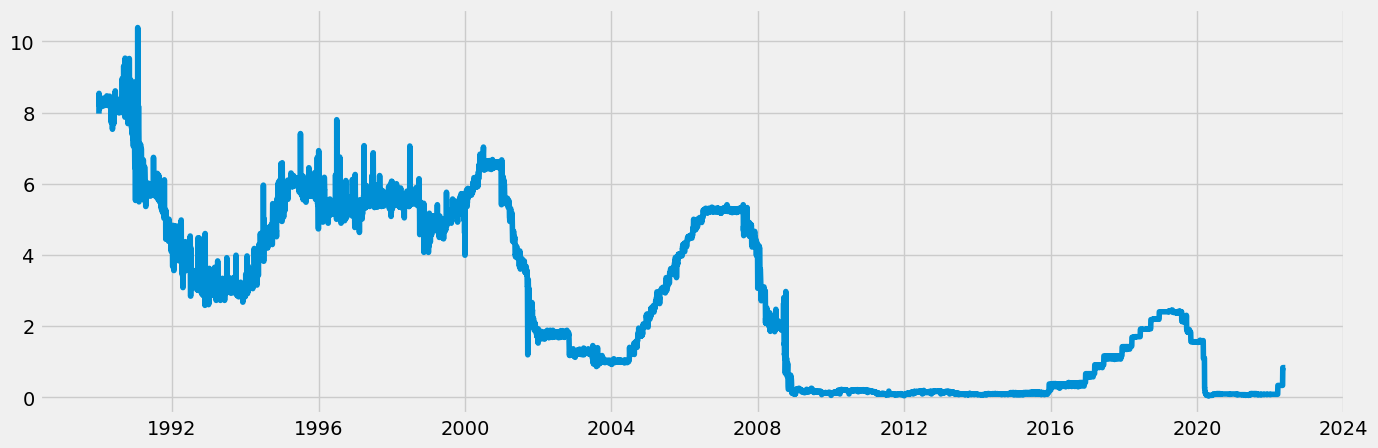

In [17]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

# STEP5 Decompose the data’s components.

## smooth data

Smoothing daily values to monthly averages can effectively eliminate random fluctuations.

In [20]:
monthly_avg = data_sub.resample('M').mean()
monthly_avg

,Value
datetime,
1990-01-31,8.229032
1990-02-28,8.237143
1990-03-31,8.276774
1990-04-30,8.255000
1990-05-31,8.176452
...,...
2022-01-31,0.079355
2022-02-28,0.080000
2022-03-31,0.200968


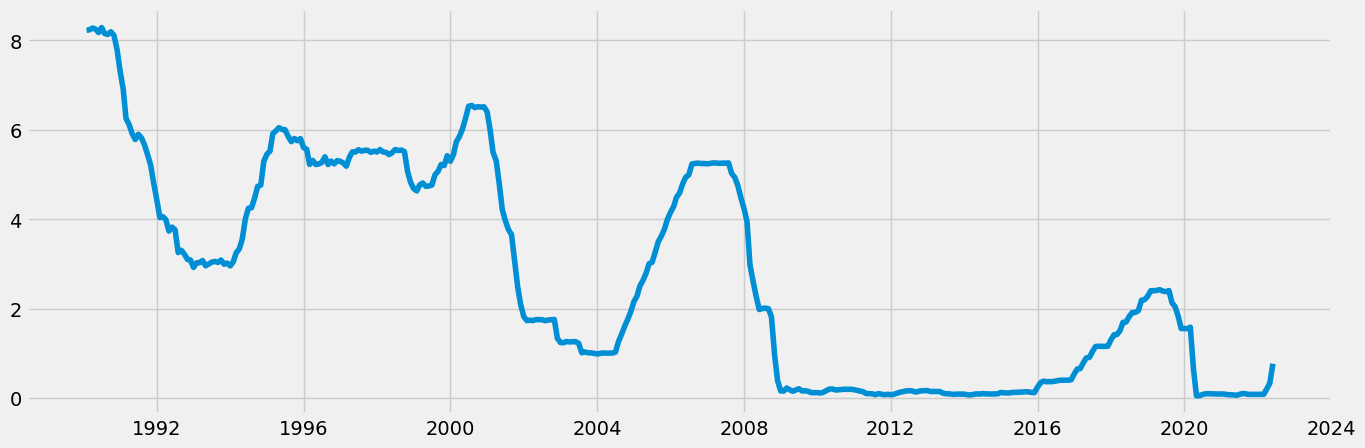

In [21]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(monthly_avg)

## decomposition

In [23]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(monthly_avg, model='additive')

In [24]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

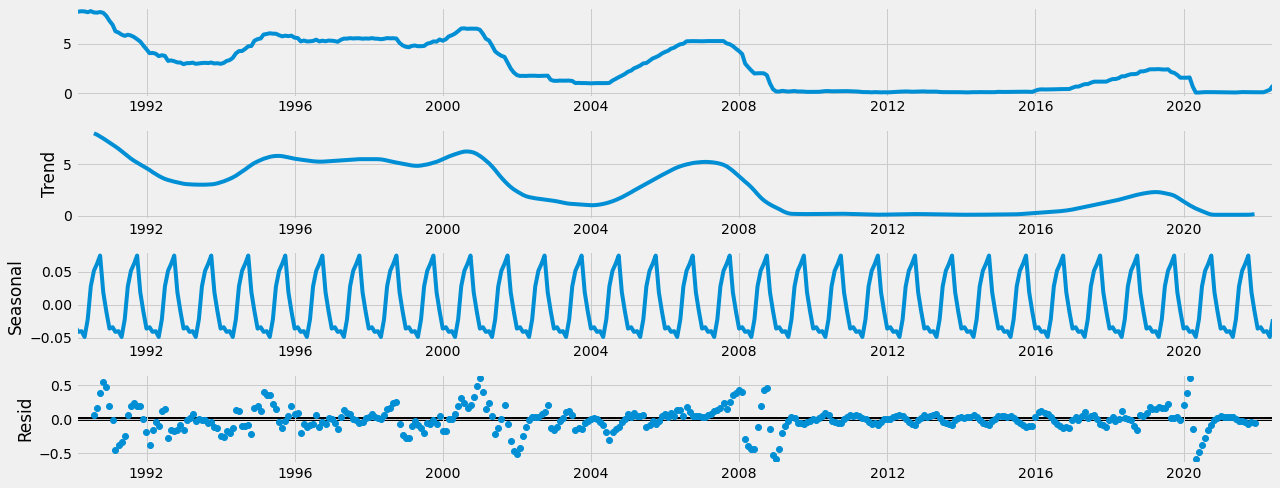

In [25]:
# Plot the separate components

decomposition.plot()
plt.show()

For trend. Observations reveal that the overall trend of the Federal Funds Rate from 1990 to 2022 is a fluctuating decline. Although the interest rate increases periodically, the peak values of these increases are successively lower.

For seasonality. We see seasonal fluctuations represented by a spikey curve that changes at a regular interval. 

For noise. Overall, the data still shows quite a bit of noise. The period with the least noise and the most stability appears to be from 2008 to 2020.

# STEP6 Dickey-Fuller test

In [28]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(monthly_avg['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -3.429332
p-value                          0.009999
Number of Lags Used              8.000000
Number of Observations Used    380.000000
Critical Value (1%)             -3.447676
Critical Value (5%)             -2.869176
Critical Value (10%)            -2.570838
dtype: float64


 The null hypothesis would be the presence of a unit root. Also means the data is not stationary data.

Based on the Test Statistic and p-value, we conclude that at a 95% confidence level, we reject the null hypothesis, indicating that the data is stationary. However, at a 99% confidence level, we cannot reject the null hypothesis, indicating that the data is not stationary.

# STEP7&8 conduct a round of differencing

In [29]:
data_diff = monthly_avg - monthly_avg.shift(1)

In [30]:
data_diff.dropna(inplace = True)

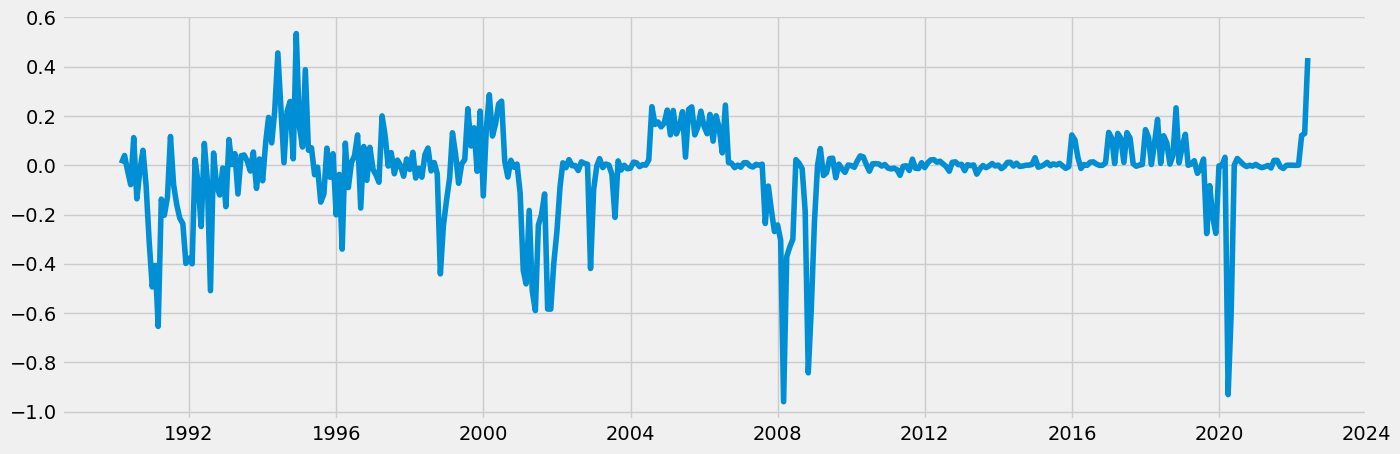

In [31]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [32]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.269533
p-value                          0.000501
Number of Lags Used              5.000000
Number of Observations Used    382.000000
Critical Value (1%)             -3.447585
Critical Value (5%)             -2.869136
Critical Value (10%)            -2.570816
dtype: float64


Now, even at a 99% confidence level, we can still reject the null hypothesis, indicating that the data is stationary.

# STEP9 Autocorrelations

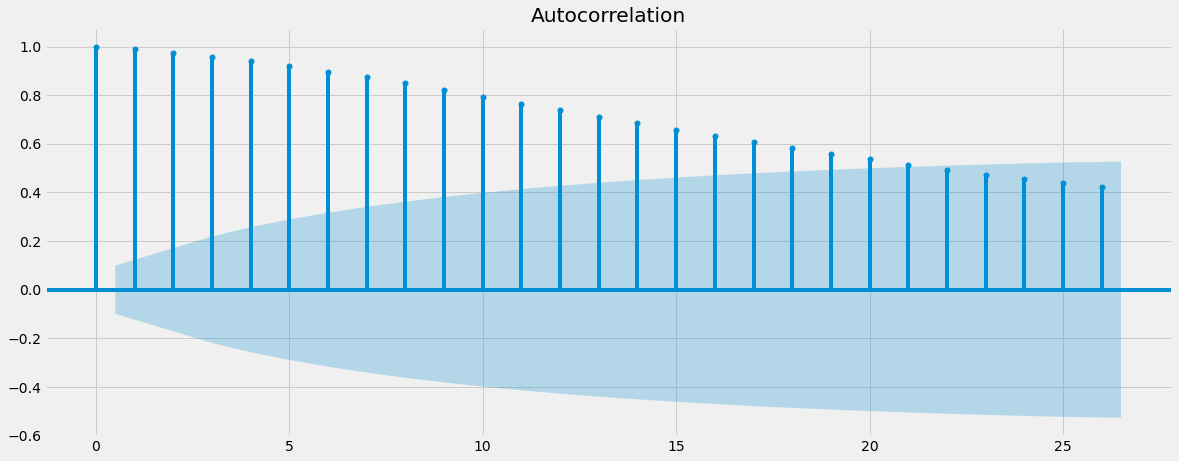

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(monthly_avg)
plt.show()

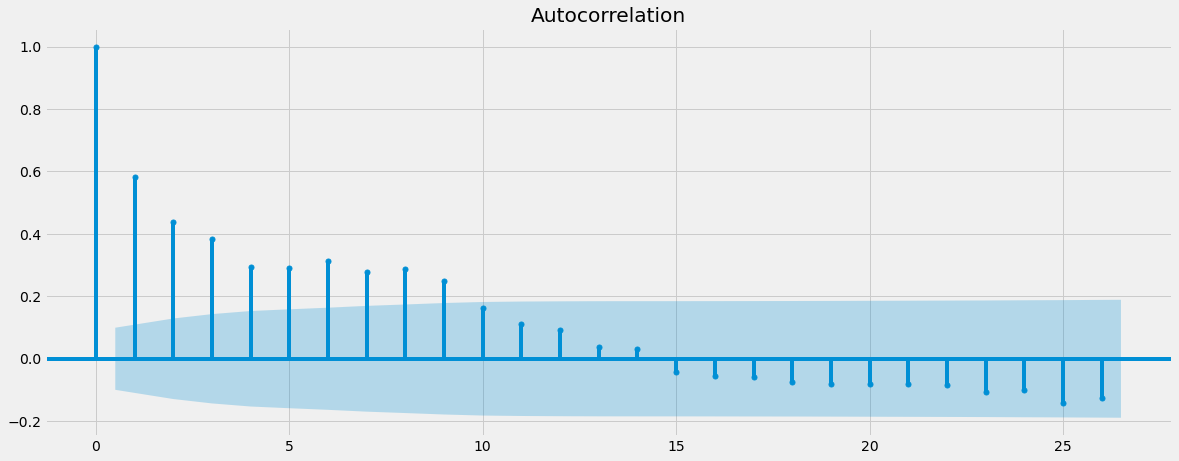

In [35]:
plot_acf(data_diff)
plt.show()